<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Chapter 4

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import dc_stat_think as dcst

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/numba/errors.py:102: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [22]:
# data prep
from urllib.request import urlretrieve
url = 'https://assets.datacamp.com/production/repositories/1067/datasets/dfefd6ab5cf704d0723ec08723c9e7c9978c1700/'
file = 'parkfield_earthquakes_1950-2017.csv'
urlretrieve(url+file, file)
df = pd.read_csv(file, skiprows=2)
df.info()

mags = df['mag'].values
gap = df['gap'].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9991 entries, 0 to 9990
Data columns (total 26 columns):
time               9991 non-null object
latitude           9991 non-null float64
longitude          9991 non-null float64
depth              9991 non-null float64
mag                9991 non-null float64
magType            9991 non-null object
nst                9990 non-null float64
gap                9990 non-null float64
dmin               9959 non-null float64
rms                9989 non-null float64
net                9991 non-null object
id                 9991 non-null object
updated            9991 non-null object
place              9991 non-null object
type               9991 non-null object
horizontalError    9988 non-null float64
depthError         9989 non-null float64
magError           8664 non-null float64
magNst             9990 non-null float64
status             9991 non-null object
locationSource     9991 non-null object
magSource          9991 non-null object
l

In [23]:
mags.shape, gap.shape

((9991,), (9991,))

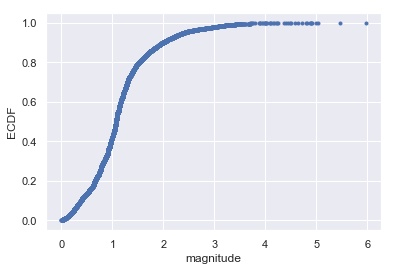

In [11]:
# Make the plot
_ = plt.plot(*dcst.ecdf(mags), marker='.', linestyle='none')

# Label axes and show plot
_ = plt.xlabel('magnitude')
_ = plt.ylabel('ECDF')
plt.show()


In [12]:
def b_value(mags, mt, perc=[2.5, 97.5], n_reps=None):
    """Compute the b-value and optionally its confidence interval."""
    # Extract magnitudes above completeness threshold: m
    m = mags[mags >= mt]

    # Compute b-value: b
    b = (np.mean(m)-mt)*np.log(10)

    # Draw bootstrap replicates
    if n_reps is None:
        return b
    else:
        m_bs_reps = dcst.draw_bs_reps(m, np.mean, size=n_reps)

        # Compute b-value from replicates: b_bs_reps
        b_bs_reps = (m_bs_reps - mt) * np.log(10)

        # Compute confidence interval: conf_int
        conf_int = np.percentile(b_bs_reps, perc)
    
        return b, conf_int

In [17]:
# own test
mt = 3.0
b_value(mags, mt, n_reps=10000)

(1.0832383648596433, array([0.93832901, 1.23848633]))

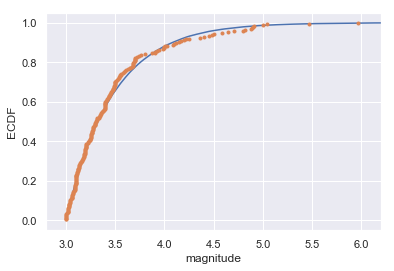


b-value: 1.08
95% conf int: [0.94, 1.24]


In [21]:
# Compute b-value and confidence interval
b, conf_int = b_value(mags, mt, perc=[2.5, 97.5], n_reps=10000)

# Generate samples to for theoretical ECDF
m_theor = np.random.exponential(b/np.log(10), size=100000) + mt

# Plot the theoretical CDF
_ = plt.plot(*dcst.ecdf(m_theor))

# Plot the ECDF (slicing mags >= mt)
_ = plt.plot(*dcst.ecdf(mags[mags >= mt]), marker='.', linestyle='none')

# Pretty up and show the plot
_ = plt.xlabel('magnitude')
_ = plt.ylabel('ECDF')
_ = plt.xlim(2.8, 6.2)
plt.show()

# Report the results
print("""
b-value: {0:.2f}
95% conf int: [{1:.2f}, {2:.2f}]""".format(b, *conf_int))

In [24]:
# data prep
time_gap = np.array([24.06570842, 20.07665982, 21.01848049, 12.24640657, 32.05475702,
       38.2532512 ])

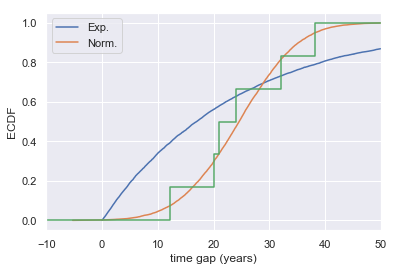

In [26]:
# Compute the mean time gap: mean_time_gap
mean_time_gap = np.mean(time_gap)

# Standard deviation of the time gap: std_time_gap
std_time_gap = np.std(time_gap)

# Generate theoretical Exponential distribution of timings: time_gap_exp
time_gap_exp = np.random.exponential(mean_time_gap, size=10000)

# Generate theoretical Normal distribution of timings: time_gap_norm
time_gap_norm = np.random.normal(mean_time_gap, std_time_gap, size=10000)

# Plot theoretical CDFs
_ = plt.plot(*dcst.ecdf(time_gap_exp))
_ = plt.plot(*dcst.ecdf(time_gap_norm))

# Plot Parkfield ECDF
_ = plt.plot(*dcst.ecdf(time_gap, formal=True, min_x=-10, max_x=50))

# Add legend
_ = plt.legend(('Exp.', 'Norm.'), loc='upper left')

# Label axes, set limits and show plot
_ = plt.xlabel('time gap (years)')
_ = plt.ylabel('ECDF')
_ = plt.xlim(-10, 50)
plt.show()

In [28]:
today = 2019.0764961745679
last_quake = 2004.74

In [30]:
# Draw samples from the Exponential distribution: exp_samples
exp_samples = np.random.exponential(mean_time_gap, size=100000)

# Draw samples from the Normal distribution: norm_samples
norm_samples = np.random.normal(mean_time_gap, std_time_gap, size=100000)

# No earthquake as of today, so only keep samples that are long enough
exp_samples = exp_samples[exp_samples > today - last_quake]
norm_samples = norm_samples[norm_samples > today - last_quake]

# Compute the confidence intervals with medians
conf_int_exp = np.percentile(exp_samples, [2.5, 50, 97.5]) + last_quake
conf_int_norm = np.percentile(norm_samples, [2.5, 50, 97.5]) + last_quake

# Print the results
print('Exponential:', conf_int_exp)
print('     Normal:', conf_int_norm)

Exponential: [2019.72149089 2036.23974175 2109.87016241]
     Normal: [2020.01226494 2030.56871978 2046.32222537]


In [32]:
def ks_stat(data1, data2):
    # Compute ECDF from data: x, y
    x, y = dcst.ecdf(data1)
    
    # Compute corresponding values of the target CDF
    cdf = dcst.ecdf_formal(x, data2)

    # Compute distances between concave corners and CDF
    D_top = y - cdf

    # Compute distance between convex corners and CDF
    D_bottom = cdf - y + 1 / len(data1)

    return np.max((D_top, D_bottom))

In [36]:
def draw_ks_reps(n, f, args=(), size=10000, n_reps=10000):
    # Generate samples from target distribution
    x_f = f(*args, size=size)
    
    # Initialize K-S replicates
    reps = np.empty(n_reps)
    
    # Draw replicates
    for i in range(n_reps):
        # Draw samples for comparison
        x_samp = f(*args, size=n)
        
        # Compute K-S statistic
        reps[i] = dcst.ks_stat(x_samp, x_f)

    return reps

In [39]:
# Draw target distribution: x_f
x_f = np.random.exponential(mean_time_gap, size=10000)

# Compute K-S stat: d
d = dcst.ks_stat(time_gap, x_f)

# Draw K-S replicates: reps
reps = dcst.draw_ks_reps(len(time_gap), np.random.exponential, 
                         args=(mean_time_gap,), size=10000, n_reps=10000)

# Compute and print p-value
p_val = np.sum(reps >= d) / 10000
print('p =', p_val)

p = 0.2474
